# Module 1. Personalize User-Item Interaction Data 준비 및 환경 설정


## Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [18]:
# Imports
!pip install jsonlines
#from codes import lambda_personalize
import boto3
import json
import numpy as np
import pandas as pd
import time
import jsonlines

from datetime import datetime
import sagemaker
import time
import warnings

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
from botocore.exceptions import ClientError

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


다음으로 여러분의 환경이 Amazon Personalize와 성공적으로 통신할 수 있는지 확인해야 합니다.

In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
s3 = boto3.resource('s3')

생성할 오브젝트의 끝에 임의의 숫자를 부여하기 위해 suffix 정의

In [3]:
# If you don't need profile, set USER_PROFILE=""
PROFILE_NAME="Kurly"


WORK_DATE="20200612"
WORK_DATE_PATH="2020/06/12"

data_dir = "poc_data"
account_id = "870180618679"

#INTERACTION_FILE_1="46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv"
INTERACTION_FILE="f1355121-d9fe-4aaa-b3df-37f35f344384.csv"
#INTERACTION_FILE="interactions_" + WORK_DATE +".csv"

BUCKET_NAME = "jihys-personal"
KEY_PREFIX = "kurly"

PREFIX = "data03/user+identifier/" + WORK_DATE_PATH

DATA_BUCKET_NAME = "jihys-personal"
bucket=DATA_BUCKET_NAME 
#DATA_BUCKET_NAME = account_id + "-kurly-personalize-0324"
#bucket_name = DATA_BUCKET_NAME
ROLE_NAME = "Kurly-PersonalizeRetailRole-0612"
DATA_PREFIX = "dataset"
BATCH_PREFIX= "batch"
#INTERACTIONS="interaction_" + WORK_DATE + ".csv"
#MEMBERS="member_" + WORK_DATE + ".csv"
#PRODUCTS="product_" + WORK_DATE + ".csv"

DATA_SET_GROUP_NAME= WORK_DATE+ "-dataset-group"
SCHEMA_NAME_INTERACTION= WORK_DATE+ "-schema-interactions"
#SCHEMA_NAME_USERS= PREFIX + "-schema-users"
#SCHEMA_NAME_ITEMS= PREFIX + "-schema-items"

DATASET_NAME_INTERACTION="kurly-dataset-interactions"
DATASET_NAME_USERS="kurly-dataset-users"
DATASET_NAME_ITEMS="kurly-dataset-items"

suffix = str(np.random.uniform())[4:9]

BATCH_TARGET_USERS_FILE= "users_for_batch_"+ WORK_DATE + ".json"


### 데이터 세트 다운로드 및 탐색

In [4]:

source_file_path = KEY_PREFIX +"/"+PREFIX+"/"+INTERACTION_FILE
target_file_path = data_dir+"/"+INTERACTION_FILE
print(source_file_path)
print(target_file_path)


#s3.Bucket(BUCKET_NAME).download_file('kurly/data03/user+identifier/2020/06/12/46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv', target_file_path)
s3.Bucket(BUCKET_NAME).download_file(source_file_path, target_file_path)


kurly/data03/user+identifier/2020/06/12/f1355121-d9fe-4aaa-b3df-37f35f344384.csv
poc_data/f1355121-d9fe-4aaa-b3df-37f35f344384.csv


In [5]:
#df_1=pd.read_csv('poc_data/46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv')
#df_2=pd.read_csv('poc_data/f1355121-d9fe-4aaa-b3df-37f35f344384.csv')

df=pd.read_csv(target_file_path)
#print(df_1.head())
#print(df_2.head())
#df=pd.concat(df_1, df_2)
df.columns=['EVENT_TYPE','USER_ID','ITEM_ID','TIMESTAMP']
df_origin=df
df.head()


,EVENT_TYPE,USER_ID,ITEM_ID,TIMESTAMP
0,click,2358D2214F28D1226464E33B3AC111D9,E41FA3D414E8EACA9467ECACE739B400,1.590865e+12
1,click,8E535A9C69DDFB4CE9004A395150BA27,F09A9EAE79258394989C32E851C9EC10,1.590865e+12
2,click,CA766DED13E4B52143576087E4054365,0B6ACE9E8971CF36F1782AA982A708DB,1.590865e+12
3,click,1A4B4636C84ADBA079DC12F80EF3E134,43D5B8FC1B0674E7CFD04C36D6BB6442,1.590865e+12
4,click,BECB61EA11D2672B317052C6B29F870A,68D13CF26C4B4F4F932E3EFF990093BA,1.590865e+12


In [6]:
df=df_origin.copy()
df.dtypes

EVENT_TYPE     object
USER_ID        object
ITEM_ID        object
TIMESTAMP     float64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61876589 entries, 0 to 61876588
Data columns (total 4 columns):
EVENT_TYPE    object
USER_ID       object
ITEM_ID       object
TIMESTAMP     float64
dtypes: float64(1), object(3)
memory usage: 1.8+ GB


### NULL DATA제거 

In [8]:
print("# of rows of Null TimeStamp : {}".format(df['TIMESTAMP'].isnull().sum()))
print("# of rows of Null Event Type : {}".format(df['EVENT_TYPE'].isnull().sum()))
print("# of rows of Null User ID : {}".format(df['USER_ID'].isnull().sum()))
print("# of rows of Null Item ID : {}".format(df['ITEM_ID'].isnull().sum()))
#df[df['TIMESTAMP'].isnull()]

#########전체 INTERACTION 'null' 확인##########
#row_has_NaN = is_NaN.any(axis=1)
#rows_with_NaN = df[row_has_NaN]
#print(rows_with_NaN)
#len(rows_with_NaN)
##############################################

# of rows of Null TimeStamp : 333331
# of rows of Null Event Type : 0
# of rows of Null User ID : 0
# of rows of Null Item ID : 6


In [9]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61543252 entries, 0 to 61876588
Data columns (total 4 columns):
EVENT_TYPE    object
USER_ID       object
ITEM_ID       object
TIMESTAMP     float64
dtypes: float64(1), object(3)
memory usage: 2.3+ GB


### 데이터 타입 확인 및 변경

In [10]:
###Test Code to see timestamp format
#arb_time_stamp = df.iloc[50]['TIMESTAMP']
#print(arb_time_stamp)
#print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))


In [11]:
df.TIMESTAMP  = df.TIMESTAMP / 1000
arb_time_stamp = df.iloc[50]['TIMESTAMP']
print(arb_time_stamp)
print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

1590864667.87
2020-05-30 18:51:07


In [20]:

print("from",datetime.utcfromtimestamp(df['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )

from 2020-04-21 04:39:00 to 2020-06-02 19:59:59


In [ ]:
df.EVENT_TYPE = df.EVENT_TYPE .astype(str)
df.ITEM_ID = df.ITEM_ID.astype(str)
df.USER_ID = df.USER_ID.astype(str)
df.TIMESTAMP=df.TIMESTAMP.astype('int64')

In [ ]:
item,item_unique=pd.factorize(df['ITEM_ID'])
user,user_unique=pd.factorize(df['USER_ID'])
df['ITEM_ID']=item
df['USER_ID']=user

In [ ]:
df.tail()

In [ ]:
item_unique=pd.DataFrame(item_unique,columns=['ITEM_ID'])
user_unique=pd.DataFrame(user_unique,columns=['USER_ID'])
item_unique.to_csv(data_dir + "/"+"unique_item_index.csv")
user_unique.to_csv(data_dir + "/"+"unique_user_index.csv")

### 데이터 INTERACTION 정보 확인

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록

In [21]:
unique_items = df['ITEM_ID'].unique()
unique_users = df['USER_ID'].unique()
print("unique_items: {}, Unique_users : {}".format(len(unique_items),len(unique_users)))

unique_items: 10433, Unique_users : 1593566


In [22]:
df.head()

,EVENT_TYPE,USER_ID,ITEM_ID,TIMESTAMP
0,click,2358D2214F28D1226464E33B3AC111D9,E41FA3D414E8EACA9467ECACE739B400,1.590865e+09
1,click,8E535A9C69DDFB4CE9004A395150BA27,F09A9EAE79258394989C32E851C9EC10,1.590865e+09
2,click,CA766DED13E4B52143576087E4054365,0B6ACE9E8971CF36F1782AA982A708DB,1.590865e+09
3,click,1A4B4636C84ADBA079DC12F80EF3E134,43D5B8FC1B0674E7CFD04C36D6BB6442,1.590865e+09
4,click,BECB61EA11D2672B317052C6B29F870A,68D13CF26C4B4F4F932E3EFF990093BA,1.590865e+09


click    50963282
order    10579970
Name: EVENT_TYPE, dtype: int64


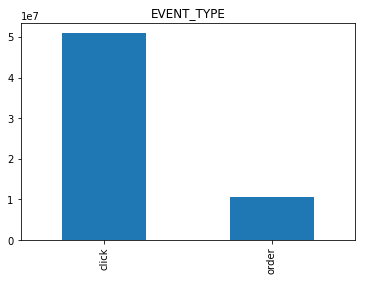

In [23]:
#for col in category_feature:
#    print("%s column is processing" % (col))
print(df.EVENT_TYPE.value_counts())
df.EVENT_TYPE.value_counts().plot(kind='bar')
plt.title("EVENT_TYPE")

plt.show()

In [24]:
user_activity_counts = df.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
print(user_activity_counts.info())
user_activity_counts.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1593566 entries, 00000798964B0E50F229649313A316BC to FFFFF91F35D7F58D8E63A8500EC86389
Data columns (total 1 columns):
INTERACTION_COUNTS    1593566 non-null int64
dtypes: int64(1)
memory usage: 24.3+ MB
None


,INTERACTION_COUNTS
USER_ID,
00000798964B0E50F229649313A316BC,1
0000136D22B0F310C711DC7CEFFAB2EB,23
000016B055E48C09079951E895371491,16
00001BF330801C5FF0FA40D34784356F,1
00002189884F3922A12B4A7E6ACF827F,72


In [25]:
user_activity_counts.quantile([.1,.2,.3,.4,.5,.6,.8,.9,.95,.99,.999,.9999,1.0])

,INTERACTION_COUNTS
0.1000,1.0
0.2000,3.0
0.3000,5.0
0.4000,8.0
0.5000,13.0
0.6000,21.0
0.8000,53.0
0.9000,98.0
0.9500,158.0
0.9900,353.0


In [26]:
user_activity_counts=user_activity_counts.reset_index()
activities = user_activity_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities.head()

,NUM_USERS
INTERACTION_COUNTS,
1,184713
2,117891
3,85866
4,68402
5,57207


In [27]:
assert (len(unique_users)==activities['NUM_USERS'].sum())

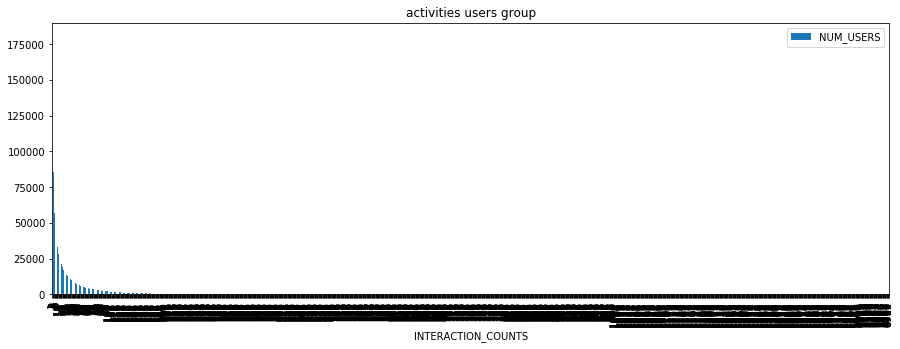

In [28]:
activities.loc[:8712,:].plot(kind='bar', figsize=(15,5), ylim=(0,190000))
plt.title("activities users group")

plt.show()

In [29]:
activities[activities.index > 24].NUM_USERS.sum()

582580

In [30]:
df.groupby("USER_ID").count().mean()

EVENT_TYPE    38.619833
ITEM_ID       38.619833
TIMESTAMP     38.619833
dtype: float64

In [31]:
#user_activity_counts['INTERACTION_COUNTS'].max()
heavy_user=user_activity_counts[user_activity_counts['INTERACTION_COUNTS']>1518]
heavy_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 7115 to 1581902
Data columns (total 2 columns):
USER_ID               159 non-null object
INTERACTION_COUNTS    159 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [32]:
#user_activity_counts['INTERACTION_COUNTS'].max()
slow_user=user_activity_counts[user_activity_counts['INTERACTION_COUNTS']<=24]
print(slow_user.info())
print("slow_user_percentage:{}".format(len(slow_user)/len(user_activity_counts)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010986 entries, 0 to 1593565
Data columns (total 2 columns):
USER_ID               1010986 non-null object
INTERACTION_COUNTS    1010986 non-null int64
dtypes: int64(1), object(1)
memory usage: 23.1+ MB
None
slow_user_percentage:0.6344174009736654


### 아이템 분석

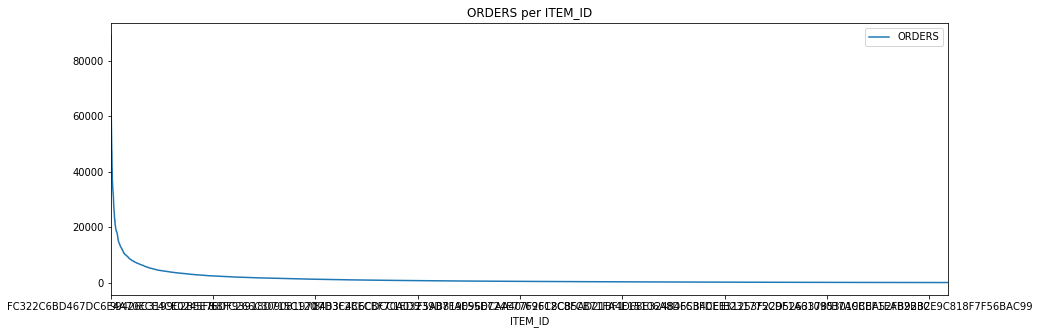

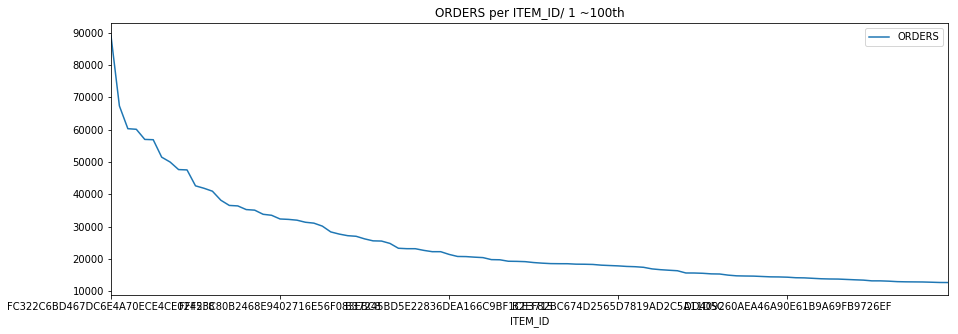

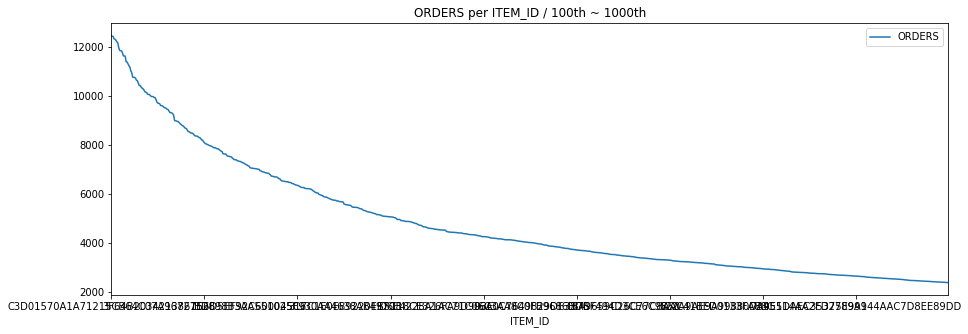

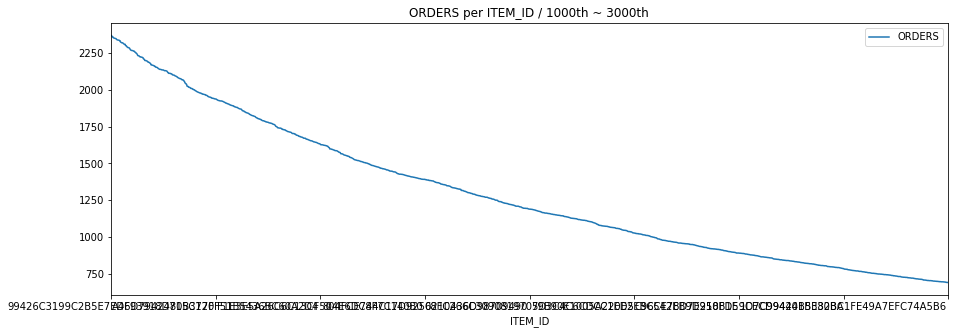

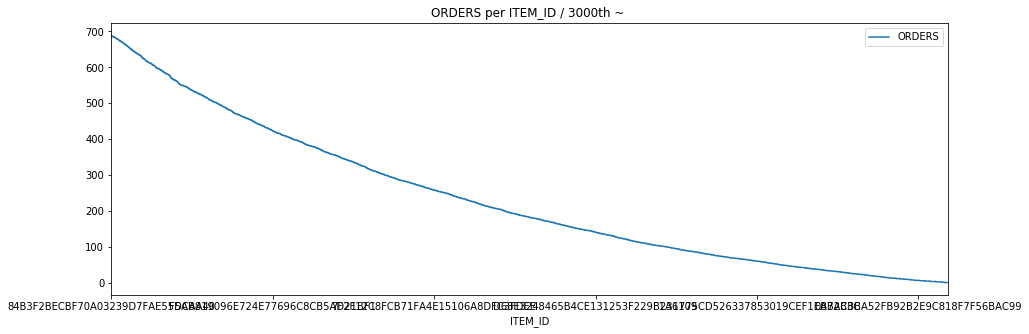

In [33]:
def draw_long_tails(df, is_in_event_types, groupby_column_name, count_name, range1=100, range2=1000, range3=3000):
    filtered_df = df.loc[df["EVENT_TYPE"].isin(is_in_event_types)]
    groupby_df = filtered_df.groupby(groupby_column_name).count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":count_name})
    sorted_df = groupby_df.sort_values([count_name], ascending=False)
    
    sorted_df[:].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name)
    plt.show()

    sorted_df[:range1].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + "/ 1 ~" + str(range1) + "th")
    plt.show()
    
    sorted_df[range1:range2].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range1) + "th ~ "+ str(range2) + "th")
    plt.show()

    sorted_df[range2:range3].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range2) + "th ~ "+ str(range3) + "th")
    plt.show()
    
    sorted_df[range3:].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range3) + "th ~ ")
    plt.show()
    
#draw_long_tails(interactions_org, ["order"], "ITEM_ID", "ORDERS", 100, 1000, 3000)
draw_long_tails(df, ["order"], "ITEM_ID", "ORDERS", 100, 1000, 3000)

### 데이터 S3 업로드 

In [60]:
# File upload에 몇분 소요 (600MB)
interaction_object_key = "refined_interactions_" + WORK_DATE + ".csv"
df[["USER_ID","ITEM_ID","TIMESTAMP","EVENT_TYPE"]].to_csv(data_dir + "/" + interaction_object_key,index=False)

target=KEY_PREFIX+"/"+DATA_PREFIX+"/"+interaction_object_key
source=data_dir + "/" + interaction_object_key
print(target)
print(source)
boto3.Session().resource('s3').Bucket(DATA_BUCKET_NAME).Object(target).upload_file(source)


kurly/dataset/refined_interactions_20200612.csv
poc_data/refined_interactions_20200612.csv


## 스키마 생성

Personalize가 데이터를 이해하는 방법의 핵심 구성 요소는 아래 정의 된 스키마(schema)에서 비롯됩니다. 이 설정은 CSV 파일을 통해 제공된 데이터를 요약하는 방법을 Personalize 서비스에 알려줍니다. 열(column)과 유형(type)은 위에서 만든 파일의 내용과 일치합니다.

In [61]:
interaction_schema_name=SCHEMA_NAME_INTERACTION

In [63]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
       
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        { 
            "name": "EVENT_TYPE",
            "type": "string"
        },
    ],
    "version": "1.0"
}


create_schema_response = personalize.create_schema(
    name = interaction_schema_name,
    schema = json.dumps(schema)
)

interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-2:870180618679:schema/20200612-schema-interactions",
  "ResponseMetadata": {
    "RequestId": "cc0ea20c-bd1c-4e97-ad20-6855784ec04d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 05:31:12 GMT",
      "x-amzn-requestid": "cc0ea20c-bd1c-4e97-ad20-6855784ec04d",
      "content-length": "99",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [64]:
#item_schema_name="DEMO-item-schema-"+suffix

In [65]:
'''
item_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
    {
        "name": "ITEM_ID",
        "type": "string"
    },
    {
        "name": "GENRE",
        "type": "string",
        "categorical": True
    }
    ],
    "version": "1.0"
}

create_metadata_schema_response = personalize.create_schema(
    name = item_schema_name,
    schema = json.dumps(item_schema)
)

item_schema_arn = create_metadata_schema_response['schemaArn']
print(json.dumps(create_metadata_schema_response, indent=2))
'''

'\nitem_schema = {\n    "type": "record",\n    "name": "Items",\n    "namespace": "com.amazonaws.personalize.schema",\n    "fields": [\n    {\n        "name": "ITEM_ID",\n        "type": "string"\n    },\n    {\n        "name": "GENRE",\n        "type": "string",\n        "categorical": True\n    }\n    ],\n    "version": "1.0"\n}\n\ncreate_metadata_schema_response = personalize.create_schema(\n    name = item_schema_name,\n    schema = json.dumps(item_schema)\n)\n\nitem_schema_arn = create_metadata_schema_response[\'schemaArn\']\nprint(json.dumps(create_metadata_schema_response, indent=2))\n'

## 데이터 세트 그룹 생성 및 대기

Personalize에서 가장 큰 단위는 **데이터 세트 그룹(Dataset Group)** 이며, 이렇게 하면 데이터, 이벤트 추적기(event tracker), 솔루션(solution) 및 캠페인(campaign)이 분리됩니다. 공통의 데이터 수집을 공유하는 것들을 그룹화합니다. 원하는 경우 아래 그룹명을 자유롭게 변경해 주세요.

### 데이터 세트 그룹 생성

In [66]:
create_dataset_group_response = personalize.create_dataset_group(
    name = DATA_SET_GROUP_NAME
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset-group/20200612-dataset-group",
  "ResponseMetadata": {
    "RequestId": "260dbafa-ccd7-45f5-b10a-1652244b904b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 05:31:15 GMT",
      "x-amzn-requestid": "260dbafa-ccd7-45f5-b10a-1652244b904b",
      "content-length": "106",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### 데이터 세트 그룹이 활성화 상태가 될 때까지 대기

아래의 모든 항목에서 Dataset Group을 사용하려면 활성화(active)가 되어야 합니다. 아래 셀을 실행하고 DatasetGroup: ACTIVE로 변경될 때까지 기다려 주세요.

In [67]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: CREATE PENDING
DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### 데이터 세트 생성

그룹 다음으로 생성할 것은 실제 데이터 세트입니다. 아래의 코드 셀을 실행하여 데이터 세트을 생성해 주세요.

### Interaction 데이터 세트 생성

In [68]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = DATASET_NAME_INTERACTION,
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)

interaction_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset/20200612-dataset-group/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "c7a7da07-1559-46ca-b059-07fad3630083",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 05:52:39 GMT",
      "x-amzn-requestid": "c7a7da07-1559-46ca-b059-07fad3630083",
      "content-length": "108",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


###  ITEM 데이터 세트 생성 

### S3 버킷에 정책 부여

Amazon Personalize는 앞서 생성한 S3 버킷의 내용을 읽을 수 있어야 합니다. 아래 코드 셀로 S3 버킷 접근 정책(policy)을 부여합니다.

In [73]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket",
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=DATA_BUCKET_NAME, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '8A432FC717C650DB',
  'HostId': 'PfMwvTJbkzqR3Exd52Wl4SN5FRHYhrNF6e4ZT6L9Yas1kUs33MQbnWHTsHgLRA4Hrd4mvJ5X+gw=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'PfMwvTJbkzqR3Exd52Wl4SN5FRHYhrNF6e4ZT6L9Yas1kUs33MQbnWHTsHgLRA4Hrd4mvJ5X+gw=',
   'x-amz-request-id': '8A432FC717C650DB',
   'date': 'Mon, 15 Jun 2020 05:54:08 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

### Personalize IAM Role 생성

또한, Amazon Personalize는 특정 작업들을 실행할 권한을 갖기 위해, AWS에서 역할을 맡을 수 있는 기능이 필요합니다. 

In [79]:
iam = boto3.client("iam")

role_name = ROLE_NAME
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}




try:
    create_role_response = iam.create_role(
        RoleName = role_name,
        AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
    );

    iam.attach_role_policy(
        RoleName = role_name,
        PolicyArn = "arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
    );

    role_arn = create_role_response["Role"]["Arn"]
except ClientError as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']
    else:
        raise
        

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    RoleName=role_name,    
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate


print(role_arn)

arn:aws:iam::870180618679:role/Kurly-PersonalizeRetailRole-0612


### 데이터 세트 Import

이전에는 정보를 저장하기 위해 데이터 세트 그룹 및 데이터 세트를 생성했으므로, 
이제는 모델 구축을 위해 S3에서 Amazon Personalize로 데이터를 로드하는 import job을 실행합니다.

#### Interaction 데이터 세트 Import Job 생성

In [80]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "kurly-interaction-dataset-import-" + WORK_DATE,
    datasetArn = interaction_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(DATA_BUCKET_NAME, KEY_PREFIX+"/"+DATA_PREFIX+"/"+interaction_object_key)
    },
    roleArn = role_arn
)

interation_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset-import-job/kurly-interaction-dataset-import-20200612",
  "ResponseMetadata": {
    "RequestId": "cb814849-3b6b-4c50-950e-1ec7cbbc5ede",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 06:06:47 GMT",
      "x-amzn-requestid": "cb814849-3b6b-4c50-950e-1ec7cbbc5ede",
      "content-length": "134",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [81]:
#store values 세션 끊길거 대비 
%store BUCKET_NAME
%store DATA_BUCKET_NAME
%store dataset_group_arn
%store interaction_dataset_arn
%store interation_dataset_import_job_arn
%store role_name
%store role_arn

Stored 'BUCKET_NAME' (str)
Stored 'DATA_BUCKET_NAME' (str)
Stored 'dataset_group_arn' (str)
Stored 'interaction_dataset_arn' (str)
Stored 'interation_dataset_import_job_arn' (str)
Stored 'role_name' (str)
Stored 'role_arn' (str)


#### 아이템 데이터 세트 Import Job 생성

### 데이터 세트 Import job이 활성화 상태가 될 때까지 대기

Import job이 완료되기까지 시간이 걸립니다. 아래 코드 셀의 출력 결과가 DatasetImportJob: ACTIVE가 될 때까지 기다려 주세요.

In [82]:
%%time

status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = interation_dataset_import_job_arn
    )
    
    dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
    if "latestDatasetImportJobRun" not in dataset_import_job:
        status = dataset_import_job["status"]
        print("DatasetImportJob: {}".format(status))
    else:
        status = dataset_import_job["latestDatasetImportJobRun"]["status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE
CPU times: user 83.1 ms, sys: 13.2 ms, total: 96.3 ms
Wall time: 16min 1s


## 솔루션 생성 

In [83]:
 # Recipe 선택 
hrnn_recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn"

In [84]:
# Solution 생성 
create_solution_response = personalize.create_solution(
    name = "Kurly-hrnn-" + WORK_DATE,
    datasetGroupArn = dataset_group_arn,
    recipeArn = hrnn_recipe_arn,
)

hrnn_solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:ap-northeast-2:870180618679:solution/Kurly-hrnn-20200612",
  "ResponseMetadata": {
    "RequestId": "93b47101-7bfb-48b0-83db-808196da65e8",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 06:22:48 GMT",
      "x-amzn-requestid": "93b47101-7bfb-48b0-83db-808196da65e8",
      "content-length": "94",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [85]:
# 솔루션 버전 생성
create_solution_version_response = personalize.create_solution_version(
    solutionArn = hrnn_solution_arn
)

hrnn_solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-northeast-2:870180618679:solution/Kurly-hrnn-20200612/0e31a272",
  "ResponseMetadata": {
    "RequestId": "7430eb85-36b4-47d0-b712-d3b74d1f6817",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 06:22:48 GMT",
      "x-amzn-requestid": "7430eb85-36b4-47d0-b712-d3b74d1f6817",
      "content-length": "110",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [92]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
      
    #hrnn status
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = hrnn_solution_version_arn
    )  
    status_hrnn = describe_solution_version_response["solutionVersion"]["status"]
    print("HRNN SolutionVersion: {}".format(status_hrnn))
       
    if  (status_hrnn == "ACTIVE" or status_hrnn == "CREATE FAILED"):
        break
 
    time.sleep(60)

print("All solution creation completed")

HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVersion: CREATE IN_PROGRESS
HRNN SolutionVer

In [93]:
%store hrnn_solution_version_arn
%store hrnn_solution_arn


Stored 'hrnn_solution_version_arn' (str)
Stored 'hrnn_solution_arn' (str)


## 솔루션 평가하기 

In [94]:
%store -r

In [95]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = hrnn_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))



{
  "solutionVersionArn": "arn:aws:personalize:ap-northeast-2:870180618679:solution/Kurly-hrnn-20200612/0e31a272",
  "metrics": {
    "coverage": 0.746,
    "mean_reciprocal_rank_at_25": 0.257,
    "normalized_discounted_cumulative_gain_at_10": 0.2976,
    "normalized_discounted_cumulative_gain_at_25": 0.3336,
    "normalized_discounted_cumulative_gain_at_5": 0.2647,
    "precision_at_10": 0.0595,
    "precision_at_25": 0.033,
    "precision_at_5": 0.0882
  },
  "ResponseMetadata": {
    "RequestId": "5c19a2c3-f82b-4d3e-939d-bbd50b126882",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 15 Jun 2020 09:27:45 GMT",
      "x-amzn-requestid": "5c19a2c3-f82b-4d3e-939d-bbd50b126882",
      "content-length": "405",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Batch Inference

In [ ]:
batch_target_users = df.USER_ID.unique()

BATCH_TARGET_USERS_FILE= "users_for_batch_"+ WORK_DATE + ".json"

n = 0
f = open(data_dir+"/"+BATCH_TARGET_USERS_FILE,"w")
for user in batch_target_users:
    f.write("{\"userId\":\"%s\"}\n" % user)
    n = n + 1
    #for the test
    #if n> 100:
    #    break
    
f.close()
print(BATCH_TARGET_USERS_FILE)
print(n)

In [5]:
# Upload files to S3
S3_BATCH_FILE_PATH=KEY_PREFIX+"/"+"batch"+"/"

boto3.Session().resource('s3').Bucket(DATA_BUCKET_NAME).Object(S3_BATCH_FILE_PATH+BATCH_TARGET_USERS_FILE).upload_file(data_dir+"/"+BATCH_TARGET_USERS_FILE)

s3_input_path = "s3://" + DATA_BUCKET_NAME + "/"+S3_BATCH_FILE_PATH+BATCH_TARGET_USERS_FILE
print(s3_input_path)

s3://jihys-personal/kurly/batch/users_for_batch_20200612.json


In [6]:
# Define the output path
s3_output_path = "s3://" +DATA_BUCKET_NAME +"/"+S3_BATCH_FILE_PATH
print(s3_output_path)

s3://jihys-personal/kurly/batch/


In [102]:
batchInferenceJobArn = personalize.create_batch_inference_job (
    solutionVersionArn = hrnn_solution_version_arn,
    jobName = "Kurly-Batch-Inference-Job-HRNN-"+WORK_DATE+suffix,
    roleArn = role_arn,
    jobInput = 
     {"s3DataSource": {"path": s3_input_path}},
    jobOutput = 
     {"s3DataDestination":{"path": s3_output_path}}
)
batchInferenceJobArn = batchInferenceJobArn['batchInferenceJobArn']

In [104]:
current_time = datetime.now()
print("Import Started on: ", current_time.strftime("%I:%M:%S %p"))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_inference_job_response = personalize.describe_batch_inference_job(
        batchInferenceJobArn = batchInferenceJobArn
    )
    status = describe_dataset_inference_job_response["batchInferenceJob"]['status']
    print("DatasetInferenceJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)
    
current_time = datetime.now()
print("Import Completed on: ", current_time.strftime("%I:%M:%S %p"))

Import Started on:  01:08:05 PM
DatasetInferenceJob: ACTIVE
Import Completed on:  01:08:05 PM


In [8]:
s3 = boto3.client('s3')
export_name = BATCH_TARGET_USERS_FILE + ".out"

s3.download_file(DATA_BUCKET_NAME,S3_BATCH_FILE_PATH+export_name,data_dir+"/"+export_name)
print(S3_BATCH_FILE_PATH+export_name,data_dir+"/"+export_name)
# Update DF rendering
pd.set_option('display.max_rows', 30)
count=0
with open(data_dir+export_name) as json_file:
    # Get the first line and parse it
    line = json.loads(json_file.readline())
    # Do the same for the other lines
    while line:
        # extract the user ID 
        col_header = "User: " + line['input']['userId']
        # Create a list for all the artists
        recommendation_list = []
        # Add all the entries
        for item in line['output']['recommendedItems']:
            #title = get_movie_title(item)
            #recommendation_list.append(title)
            recommendation_list.append(item)
        if count>0:
            new_rec_DF = pd.DataFrame(recommendation_list, columns = [col_header])
            batch_recommendations_df = batch_recommendations_df.join(new_rec_DF)
            count+=1
        else:
            batch_recommendations_df = pd.DataFrame(recommendation_list, columns=[col_header])
            count+=1
        try:
            line = json.loads(json_file.readline())
        except:
            line = None
batch_recommendations_df
print(count)

kurly/batch/users_for_batch_20200612.json.out poc_data/users_for_batch_20200612.json.out


FileNotFoundError: [Errno 2] No such file or directory: 'poc_datausers_for_batch_20200612.json.out'

In [19]:

def read_batch_result(filename, key_name):
    result = {}
    fp = open(filename)
    reader = jsonlines.Reader(fp)
    count = 0
    for record in reader:
        result[record["input"][key_name]] = str.join(",",record["output"]["recommendedItems"])
        count += 1
    reader.close()
    fp.close()
    
    print("Found records:", count, len(result))
    return result

def unique_count(result):
    recommend_keys = {}
    
    duplicate_cnt = 0
    unique_cnt = 0
    for k in result:
        key = result[k]
        
        if key not in recommend_keys:
            unique_cnt += 1            
            recommend_keys[key] = { "count": 1, "keys": k }
        else:
            recommend_keys[key]["count"] = recommend_keys[key]["count"] + 1
            #recommend_keys[key]["keys"] = recommend_keys[key]["keys"] + "," + k
            duplicate_cnt += 1
        #print(f'dup:%10d, unique:%10d, %s is processing…\r' % (duplicate_cnt, unique_cnt, k), end="")

    return recommend_keys, unique_cnt, duplicate_cnt

hrnn_result = read_batch_result("poc_data/"+"users_for_batch_20200612.json.out", "userId")
recommend_keys, unique_cnt, duplicate_cnt = unique_count(hrnn_result)

print(f'dup:%10d, unique:%10d\n' % (duplicate_cnt, unique_cnt))
cnt = 10
for i in sorted(recommend_keys, key=lambda x: (recommend_keys[x]['count']), reverse=True):
    print(recommend_keys[i], i)
    if cnt < 0: 
        break
    cnt -=1

Found records: 1593566 1593566
dup:    218593, unique:   1374973

{'count': 4297, 'keys': '1003887'} 35,378,320,421,212,800,140,230,508,16,654,32,596,871,601,196,384,201,783,194,236,545,1253,318,232
{'count': 2621, 'keys': '1144243'} 508,92,212,35,230,574,384,800,421,871,596,1541,62,570,534,140,236,5,751,301,3090,432,1225,318,747
{'count': 1806, 'keys': '1018703'} 411,474,983,1219,1630,1212,35,292,230,212,286,800,196,136,508,421,358,871,1182,534,574,140,135,843,1541
{'count': 1783, 'keys': '1030897'} 212,230,800,508,35,2114,421,626,384,140,751,871,747,194,596,196,301,574,236,601,16,32,318,534,2319
{'count': 1681, 'keys': '1003582'} 421,37,35,230,212,800,140,601,508,2319,190,677,32,384,16,574,348,751,747,318,871,196,236,301,596
{'count': 1535, 'keys': '1037193'} 800,751,212,230,35,508,301,384,421,596,747,574,871,140,127,2319,534,236,190,196,194,16,2114,62,32
{'count': 1533, 'keys': '1072304'} 384,230,386,212,35,800,421,3253,508,407,574,751,2678,32,33,1193,2319,2114,292,974,272,92,1487,8

In [ ]:
%store batchInferenceJobArn

## 캠페인 생성하기 

In [ ]:
'''
create_campaign_response = personalize.create_campaign(
    name = "Kurly-hrnn-campaign-" + WORK_DATE,
    solutionVersionArn = hrnn_solution_version_arn,
    minProvisionedTPS = 1
)

hrnn_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))
'''

In [ ]:
'''
user_id= test_user_id
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = hrnn_campaign_arn,
    userId = str(user_id),
)
# Update DF rendering
pd.set_option('display.max_rows', 30)

print("Recommendations for user: ", user_id)

item_list = get_recommendations_response['itemList']

recommendation_title_list = []
recommendation_id_list=[]
for item in item_list:
    recommendation_title_list.append(title)
    recommendation_id_list.append(item['itemId'])
recommendations_df = pd.DataFrame(recommendation_title_list, columns = ['OriginalRecs'])
recommendations_df
'''

In [ ]:
%store hrnn_campaign_arn
